### Part 1: Building the model

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41089")
client

Client Scheduler: tcp://127.0.0.1:41089 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [5]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

In [6]:
train = pd.read_parquet(
    "s3://ling583/wine-train.parquet", storage_options={"anon": True}
)
test = pd.read_parquet(
    "s3://ling583/wine-test.parquet", storage_options={"anon": True}
)

In [7]:
train['wine_variant'].value_counts()

Pinot Noir            38471
Cabernet Sauvignon    30234
Chardonnay            19443
Syrah                 13704
Riesling               9683
Zinfandel              8327
Merlot                 5522
Sauvignon Blanc        5113
Name: wine_variant, dtype: int64

In [8]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [9]:
import multiprocessing as mp
with mp.Pool() as p:
    train["tokens"] = pd.Series(p.imap(tokenize, tqdm(train["review_text"]), chunksize=100))
    test["tokens"] = pd.Series(p.imap(tokenize, tqdm(test["review_text"]), chunksize=100))

  0%|          | 0/130497 [00:00<?, ?it/s]

  0%|          | 0/32625 [00:00<?, ?it/s]

In [7]:
train.head()

,review_text,wine_variant,tokens
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir,"[rich, smoky, dark, cherry, nose, very, intens..."
1,Had this at Corton Restaurant in NYC. First of...,Syrah,"[had, this, at, corton, restaurant, in, nyc, f..."
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir,"[nose, is, very, tart, with, a, layer, of, swe..."
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay,"[beautiful, golden, color, discrete, perfumed,..."
4,Please take the time to decant: you will not b...,Pinot Noir,"[please, take, the, time, to, decant, you, wil..."


In [8]:
test.head()

,review_text,wine_variant,tokens
0,hmmm. i have mixed emotions about this wine. o...,Chardonnay,"[hmmm, i, have, mixed, emotions, about, this, ..."
1,You can find several dozen SB Syrahs that have...,Syrah,"[you, can, find, several, dozen, sb, syrahs, t..."
2,It has a nice even red finish and remote cherr...,Pinot Noir,"[it, has, a, nice, even, red, finish, and, rem..."
3,"WIML91 Tasted October 6, 2009. Opened and se...",Pinot Noir,"[tasted, october, opened, and, served, immedia..."
4,My last bottle with the super bowl. Sipped wit...,Zinfandel,"[my, last, bottle, with, the, super, bowl, sip..."


#### SGD Classifier

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [20]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))
mlflow.set_experiment("Project2_Models")
log_test(sgd, test["wine_variant"], predicted)

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.82      0.75      7558
        Chardonnay       0.81      0.86      0.83      4861
            Merlot       0.84      0.34      0.48      1381
        Pinot Noir       0.78      0.85      0.82      9618
          Riesling       0.84      0.76      0.80      2421
   Sauvignon Blanc       0.78      0.68      0.73      1278
             Syrah       0.74      0.54      0.63      3426
         Zinfandel       0.74      0.57      0.65      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.68      0.71     32625
      weighted avg       0.76      0.76      0.75     32625



#### Lets try some other baseline models to see which performs best before beginning the hyper parameter tuning

#### Ngram model

In [10]:
from nltk import bigrams
def unibigrams(toks):
    return [(tok,) for tok in toks] + list(bigrams(toks))

In [21]:
sgd = make_pipeline(CountVectorizer(analyzer=unibigrams), SGDClassifier())
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))
mlflow.set_experiment("Project2_Models")
log_test(sgd, test["wine_variant"], predicted)

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.68      0.79      0.73      7558
        Chardonnay       0.81      0.84      0.82      4861
            Merlot       0.72      0.36      0.48      1381
        Pinot Noir       0.78      0.84      0.81      9618
          Riesling       0.81      0.78      0.79      2421
   Sauvignon Blanc       0.84      0.63      0.72      1278
             Syrah       0.66      0.56      0.61      3426
         Zinfandel       0.77      0.54      0.64      2082

          accuracy                           0.75     32625
         macro avg       0.76      0.67      0.70     32625
      weighted avg       0.75      0.75      0.74     32625



#### Baseline SGD does better. Lets try a passive aggressive classifier

In [22]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac = make_pipeline(CountVectorizer(analyzer=identity),
                    TfidfTransformer(),
                   PassiveAggressiveClassifier(max_iter=10000, random_state=0,tol=1e-5))
pac.fit(train["tokens"], train["wine_variant"])
predicted = pac.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))
mlflow.set_experiment("Project2_Models")
log_test(pac, test["wine_variant"], predicted)

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.71      0.70      0.70      7558
        Chardonnay       0.80      0.78      0.79      4861
            Merlot       0.41      0.36      0.39      1381
        Pinot Noir       0.73      0.83      0.78      9618
          Riesling       0.71      0.74      0.73      2421
   Sauvignon Blanc       0.68      0.63      0.65      1278
             Syrah       0.62      0.54      0.57      3426
         Zinfandel       0.66      0.53      0.59      2082

          accuracy                           0.71     32625
         macro avg       0.67      0.64      0.65     32625
      weighted avg       0.70      0.71      0.70     32625



#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = make_pipeline(CountVectorizer(analyzer=identity),
                   RandomForestClassifier(random_state=0))
rf.fit(train["tokens"], train["wine_variant"])
predicted = rf.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))
mlflow.set_experiment("Project2_Models")
log_test(rf, test["wine_variant"], predicted)

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.62      0.82      0.71      7558
        Chardonnay       0.76      0.87      0.81      4861
            Merlot       0.94      0.20      0.33      1381
        Pinot Noir       0.69      0.87      0.77      9618
          Riesling       0.88      0.62      0.73      2421
   Sauvignon Blanc       0.92      0.51      0.66      1278
             Syrah       0.90      0.36      0.51      3426
         Zinfandel       0.96      0.38      0.55      2082

          accuracy                           0.71     32625
         macro avg       0.83      0.58      0.63     32625
      weighted avg       0.76      0.71      0.69     32625



#### The baseline SGD seems to perform the best out of all these models. Lets continue with that for the hyperparameter tuning. We will use Dask instead of regular grid search to optimize performance

In [31]:
import mlflow
from dask_ml.model_selection import RandomizedSearchCV
from logger import log_search,log_test
from scipy.stats.distributions import loguniform, randint, uniform
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [25]:
mlflow.set_experiment("Project2_Wine")
sgd = make_pipeline(
    CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier()
)

INFO: 'Project2_Wine' does not exist. Creating a new experiment


In [28]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 20),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-6, 1e-2),
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 10.9 s, sys: 1.09 s, total: 12 s
Wall time: 6min 31s


In [29]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": [10],
        "countvectorizer__max_df": [0.7],
        "tfidftransformer__use_idf": [True],
        "sgdclassifier__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 12.2 s, sys: 1.25 s, total: 13.5 s
Wall time: 20min 24s


#### Optimised model

In [12]:
sgd = make_pipeline(
    CountVectorizer(analyzer=identity, min_df=10, max_df=0.7),TfidfTransformer(use_idf=True), SGDClassifier(alpha=7.5e-6)
)
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))
mlflow.set_experiment("Project2_Models")
log_test(sgd, test["wine_variant"], predicted)

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.71      0.80      0.75      7558
        Chardonnay       0.81      0.86      0.83      4861
            Merlot       0.77      0.34      0.47      1381
        Pinot Noir       0.77      0.87      0.82      9618
          Riesling       0.79      0.80      0.79      2421
   Sauvignon Blanc       0.83      0.66      0.73      1278
             Syrah       0.70      0.56      0.62      3426
         Zinfandel       0.83      0.52      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.68      0.71     32625
      weighted avg       0.76      0.76      0.75     32625



#### Analysing the model performance

In [27]:
import pandas as pd
x = pd.read_csv('runs (1).csv')

In [40]:
x[['Name','f1','precision','recall']].sort_values(by='f1',ascending=False).reset_index().drop('index',axis=1)

,Name,f1,precision,recall
0,Baseline SGD,0.708855,0.780704,0.675583
1,Optimised SGD,0.708842,0.776675,0.677408
2,Ngram,0.699236,0.756546,0.668048
3,Passive Aggressive Classifier,0.650416,0.666001,0.638948
4,Random Forest,0.631692,0.832433,0.578518


#### Marginal improvements to performance overall after hyperparameter tuning, but not much different from the baseline model. SGD Classifier works best overall compared to the other models that were attempted with an F1 score of 0.71. Hyperparameter tuning did not do much for the model performance. The performances are shown in the classification report and the model comparison reports above. We will continue with the SGD model and do further analyses.

### Pickling the model


In [13]:
import cloudpickle

In [15]:
sgd = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=tokenize, min_df=10, max_df=0.7),TfidfTransformer(use_idf=True), SGDClassifier(alpha=7.5e-6)
)
sgd.fit(train["review_text"], train["wine_variant"])
predicted = sgd.predict(test["review_text"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.83      0.75      7558
        Chardonnay       0.82      0.86      0.84      4861
            Merlot       0.78      0.34      0.47      1381
        Pinot Noir       0.78      0.86      0.82      9618
          Riesling       0.80      0.79      0.80      2421
   Sauvignon Blanc       0.82      0.66      0.73      1278
             Syrah       0.73      0.55      0.63      3426
         Zinfandel       0.83      0.53      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.68      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [16]:
cloudpickle.dump(sgd, open("sgd.model", "wb"))

### Part 2: Testing model performance by analysing coefficients and words used for label assignments
#### Lets check it out for a specific example first in LIME

In [41]:
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
explainer = LimeTextExplainer(class_names=sgd.named_steps['sgdclassifier'].classes_)

In [43]:
test["wine_variant"].iloc[30003], test["review_text"].iloc[30003]

('Pinot Noir',
 'this to me is a very pleasant, somewhat innocuous Pinot. Beautiful clear cherry colour, intense typical pinot nose of strawberry and red cherry, a little candied, and not giving up any pinot "funk". Palate is medium bodied for a pinot, lots of sweet cherry and strawberry fruit, maybe a little raspberry, nice acidity and low tannins, but lacking much complexity or "wow". Solid.')

In [45]:
exp = explainer.explain_instance(
    test["review_text"].loc[30003], sgd.decision_function, num_features=15, labels=[0,1,2,3,4,5,6,7]
)

[]

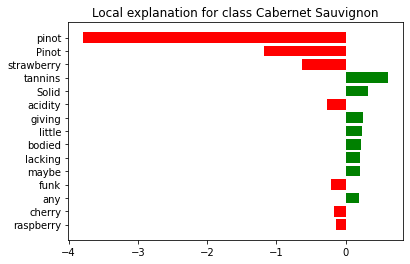

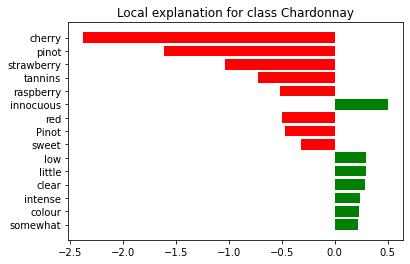

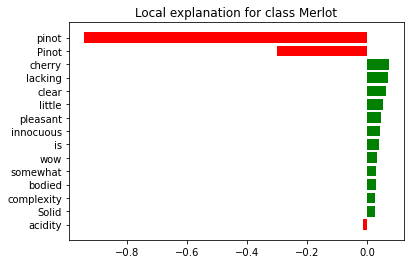

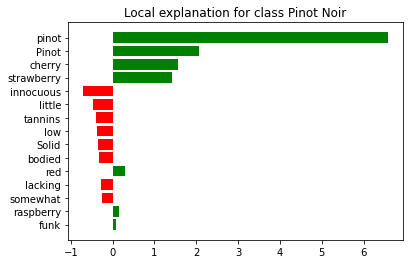

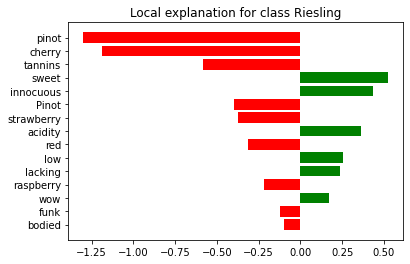

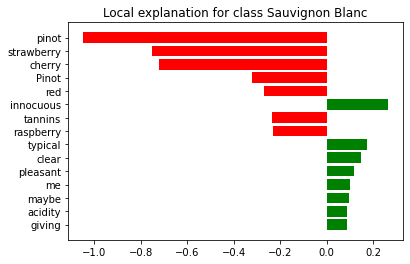

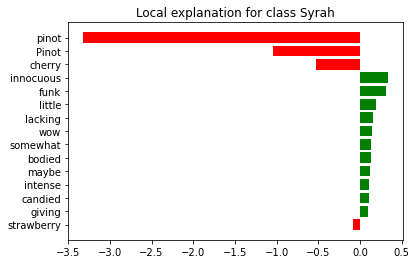

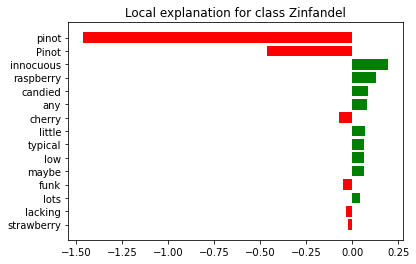

In [46]:
for i in range(0, 8):
    exp.as_pyplot_figure(i)
plt.plot()

#### As seen above the presence of the word 'Pinot' in the description plays a huge factor in the model classifying the wine variant as a pinot noir. While the name of the wine being in the description can be a pretty big indicator that the label will also be the same, it is worth questioning because the model might get confused if two wine names are named in the same review or another wine used as a reference for this wine, for example someone discribing one wine to be similar in taste to another wine in the same review. Words like cherry and strawberry on the other hand might be more generalizable and more suited to reviews of all sorts. Lets check the cofficients for all labels.

In [47]:
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
        'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18'),
 array([[ 2.97578637e-01, -1.45279913e-01,  8.97755032e-01, ...,
         -6.47085302e-02, -1.28099691e-03,  2.86392109e-01],
        [-5.31335766e-01, -2.25297300e-01, -3.16597776e-02, ...,
         -3.57139486e-02, -3.95729368e-01,  1.49969461e+00],
        [-9.72018198e-02, -9.48195067e-02, -2.86685518e-02, ...,
          6.26727805e-02, -1.56789668e-01,  0.00000000e+00],
        ...,
        [-3.25287370e-01, -1.01980678e-01,  4.31078139e-01, ...,
          1.21714101e-01, -7.07264757e-02,  0.00000000e+00],
        [-4.78026751e-01,  4.35286931e-02, -2.34511555e-01, ...,
          3.32861295e-01,  2.64498408e-01, -1.99392414e-01],
        [-2.52458667e-01, -4.77642780e-02,  0.00000000e+00, ...,
         -3.31006208e-01, -1.70508559e-01,  0.00000000e+00]]))

In [48]:
coef.shape

(8, 9972)

In [49]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names()

In [50]:
coef[0,:].argmax()

1249

In [51]:
coef[0,1249]

13.80794566153349

In [52]:
vocab[1249]

'cab'

In [53]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

Cabernet Sauvignon
  cab             13.808
  cabernet        12.686
  cabs             9.611
  cassis           8.272
  napa             5.734
  bordeaux         5.509
  currant          5.377
  bell             4.811
  tannins          4.783
  cs               4.708
  chard           -4.489
  zins            -4.542
  pinots          -4.781
  merlots         -5.037
  chardonnay      -5.132
  burgundy        -5.387
  zinfandel       -5.395
  zin             -8.068
  syrah           -9.257
  pinot           -10.056

Chardonnay
  chardonnay      12.144
  chard           10.155
  chablis          9.142
  chards           7.201
  butter           6.858
  buttery          6.802
  chardonnays      6.627
  meursault        6.297
  premox           5.491
  butterscotch     5.160
  dark            -4.732
  cab             -5.037
  cherries        -5.059
  red             -5.182
  sb              -5.354
  pinot           -5.666
  sauvignon       -6.122
  petrol          -6.482
  riesling        

#### The same pattern seems to continue for all the other wines as well. The words that the model seems to be most sensitive to seems to be the name of the wine themselves. But such occurences(two wine names in the same review) may be rare given that the model performs decently well and the training data was a decent enough sample size. There are some winery names that slip in to be some major coefficients such as Napa, paloma which seem to indicate that in the training data most of the data about those specific wines seem to be mentioned alongside those wineries, which may not always be the case with all reviews. This indicates minor signs of overfitting. Some aspects the model does well with is words that describe the taste or texture of the wines also rank very high on the coefficient scale. Words such as citrus, bacon, grassy, buttery which are good coefficients to generalize on in case the model were to be used with a different set of data.
#### Additionally, most models seem to very highly regard short forms of the wine names to be very high indicators of the review being about wine. Some of these short forms are problematic for obvious reasons, with tokens such as cab when used in the context of describing a taxi ride could be confused for a wine review by the model. But in the context of this particular dataset it makes sense for reviews to use short forms while describing the wines as well. 
#### Despite a couple of concerns, most of the coefficients seem to be in line with what is expected from reviews for those specific wine variants, so the model performs decently well.

### Part 3: Improving performance by using margin calculations and filtering the test set 

In [9]:
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["review_text"])

In [10]:
test['wine_variant'].iloc[0]

'Chardonnay'

In [11]:
test['review_text'].iloc[0]

"hmmm. i have mixed emotions about this wine. on the one hand, i like it's minerality, but on the other, i think the acid is a bit whacked. on the one hand, it's a nice combo of fruit, but it has a funky finish. in the end, i wouldn't purchase it again."

In [12]:
highest = scores.max(axis=1)

In [13]:
highest[0]

-0.8504778119942855

In [14]:
highest.argmax()

30003

In [15]:
scores[30003]

array([-6.80943017, -9.02221505, -2.24981192, 11.79412965, -5.27551711,
       -5.08102424, -5.92429665, -3.15777521])

In [16]:
test.wine_variant[30003]

'Pinot Noir'

In [17]:
test.review_text[30003]

'this to me is a very pleasant, somewhat innocuous Pinot. Beautiful clear cherry colour, intense typical pinot nose of strawberry and red cherry, a little candied, and not giving up any pinot "funk". Palate is medium bodied for a pinot, lots of sweet cherry and strawberry fruit, maybe a little raspberry, nice acidity and low tannins, but lacking much complexity or "wow". Solid.'

In [18]:
highest.argmin()

24723

In [19]:
scores[24723]

array([-4.00824839, -1.53439666, -1.51802082, -1.79124066, -2.45305552,
       -1.84514483, -2.43364501, -1.8799481 ])

In [20]:
test.wine_variant[24723]

'Pinot Noir'

In [21]:
test.review_text[24723]

'Rich leesy nose with straw, honey comb and strawberry. Bright melon and berry flavors with touches of earth and mineral. Breathy full finish. Very nice.'

In [22]:
scores.sort(axis=1)
scores[0:5,:]

array([[-1.62715477, -1.52145244, -1.24471161, -1.21932544, -1.16005582,
        -1.14180697, -1.12499989, -0.85047781],
       [-3.09240487, -2.75063856, -2.12102672, -2.09704197, -1.81297054,
        -1.33279473,  0.81793806,  1.01696489],
       [-2.25323543, -2.21613028, -2.12673723, -1.97713361, -1.51623427,
        -1.19661955, -1.15963817,  1.09263736],
       [-5.58919754, -4.68261884, -2.85799809, -1.92379267, -1.70622177,
        -1.23564225, -1.09158106,  1.66241506],
       [-4.85853427, -4.28153488, -3.33305314, -2.43838837, -2.17736738,
        -1.99627285, -1.57083007,  4.01173665]])

In [25]:
margin = scores[:,7]-scores[:,6]

In [26]:
margin.max(), margin.min()

(14.04394157158293, 0.00011321057346547203)

In [38]:
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.83      0.75      7558
        Chardonnay       0.82      0.86      0.84      4861
            Merlot       0.78      0.34      0.47      1381
        Pinot Noir       0.78      0.86      0.82      9618
          Riesling       0.80      0.79      0.80      2421
   Sauvignon Blanc       0.82      0.66      0.73      1278
             Syrah       0.73      0.55      0.63      3426
         Zinfandel       0.83      0.53      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.68      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [51]:
print(classification_report(test["wine_variant"][margin > 0.82], predicted[margin > 0.82]))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.82      0.93      0.87      5345
        Chardonnay       0.92      0.95      0.93      3784
            Merlot       0.92      0.50      0.65       872
        Pinot Noir       0.89      0.95      0.92      7550
          Riesling       0.92      0.90      0.91      1771
   Sauvignon Blanc       0.94      0.81      0.87       884
             Syrah       0.91      0.69      0.78      2058
         Zinfandel       0.95      0.74      0.83      1282

          accuracy                           0.89     23546
         macro avg       0.91      0.81      0.85     23546
      weighted avg       0.89      0.89      0.88     23546



In [53]:
32625-23546

9079

#### As seen above the margin is first calculated by subtracting the 2 highest decision function values for the labels. The model is then restricted to only those samples that score higher than a set threshold value for the margin, based on the required F1 score. Here, for an F1 of 0.85 that value was found to be 0.82 for the margin and it achieved the F1 score by excluding 9079 values from the test set. 

### Part 4: Using confusion matrices to determine model shortcomings

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [10]:
predicted = sgd.predict(test['review_text'])

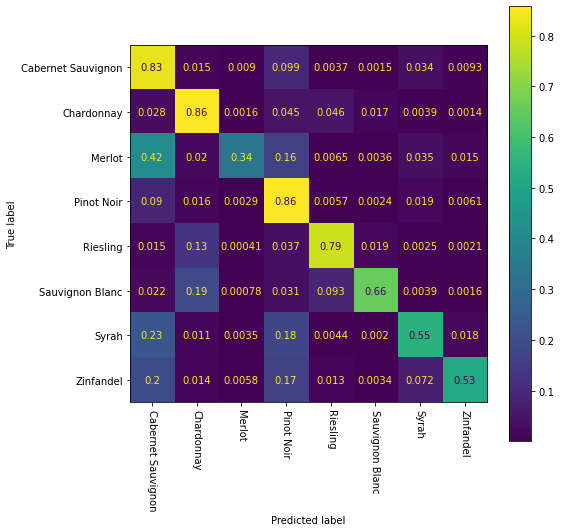

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd, test['review_text'], test['wine_variant'],xticks_rotation=-90, normalize='true', ax=ax)

#### From the model we can see that most models perform either good or average on the F1 scores, except the Zinfandel and the syrah labels as well as the merlot and Cabernet Sauvignon(Not a bad performer itself but often confused for other labels). Further, they are often confused for eachother as is visible from the 42% of Merlots that are labelled as cabernets and the 1.0% of cabernets that are labelled as Merlot. Also, Syrah and Zinfandel are bad performers themselves and are also confused for eachother 1.8% and 7.2% respectively. First, lets try and reducing the number of labels to 6, removing the Merlot and cabernet labels and replacing them with the Cabernet Sauvignon/Merlot label and removing the Syrah and Zinfandel labels and replacing them with the Syrah/Zinfandel label.

In [60]:
train

,review_text,wine_variant,tokens
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir,"[rich, smoky, dark, cherry, nose, very, intens..."
1,Had this at Corton Restaurant in NYC. First of...,Syrah,"[had, this, at, corton, restaurant, in, nyc, f..."
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir,"[nose, is, very, tart, with, a, layer, of, swe..."
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay,"[beautiful, golden, color, discrete, perfumed,..."
4,Please take the time to decant: you will not b...,Pinot Noir,"[please, take, the, time, to, decant, you, wil..."
...,...,...,...
130492,Brought this out at a dinner and it was quite ...,Zinfandel,"[brought, this, out, at, a, dinner, and, it, w..."
130493,Nothing bad to say except that this is so ordi...,Pinot Noir,"[nothing, bad, to, say, except, that, this, is..."
130494,Good wine. Dark fruit and buttery oak aromas o...,Cabernet Sauvignon,"[good, wine, dark, fruit, and, buttery, oak, a..."
130495,AP #8. Medium-deep gold. Mature nose of petrol...,Riesling,"[ap, medium, deep, gold, mature, nose, of, pet..."


In [13]:
test

,review_text,wine_variant
0,hmmm. i have mixed emotions about this wine. o...,Chardonnay
1,You can find several dozen SB Syrahs that have...,Syrah
2,It has a nice even red finish and remote cherr...,Pinot Noir
3,"WIML91 Tasted October 6, 2009. Opened and se...",Pinot Noir
4,My last bottle with the super bowl. Sipped wit...,Zinfandel
...,...,...
32620,"Had with baked potato, steak, broccoli, really...",Merlot
32621,"Vinturied one hour before first pour, consumed...",Pinot Noir
32622,Good but not great.Quite similar to some of th...,Pinot Noir
32623,"very light in color, fine mature syrah express...",Syrah


In [12]:
train_copy = train.copy()
test_copy = test.copy()

In [13]:
m = train_copy['wine_variant'].isin(['Cabernet Sauvignon', 'Merlot'])
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m, 'Cabernet Sauvignon/Merlot') 

m1 = train_copy['wine_variant'].isin(['Syrah', 'Zinfandel'])
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m1, 'Syrah/Zinfandel') 

n = test_copy['wine_variant'].isin(['Cabernet Sauvignon', 'Merlot'])
test_copy['wine_variant'] = test_copy['wine_variant'].mask(n, 'Cabernet Sauvignon/Merlot')  

n1 = test_copy['wine_variant'].isin(['Syrah', 'Zinfandel'])
test_copy['wine_variant'] = test_copy['wine_variant'].mask(n1, 'Syrah/Zinfandel')  

In [14]:
train_copy.wine_variant.value_counts()

Pinot Noir                   38471
Cabernet Sauvignon/Merlot    35756
Syrah/Zinfandel              22031
Chardonnay                   19443
Riesling                      9683
Sauvignon Blanc               5113
Name: wine_variant, dtype: int64

In [15]:
test_copy.wine_variant.value_counts()

Pinot Noir                   9618
Cabernet Sauvignon/Merlot    8939
Syrah/Zinfandel              5508
Chardonnay                   4861
Riesling                     2421
Sauvignon Blanc              1278
Name: wine_variant, dtype: int64

#### Lets test the model on this new data and see if there is any improvement in performance

In [16]:
sgd1 = cloudpickle.load(open('sgd.model','rb'))

In [17]:
sgd1.fit(train_copy["review_text"], train_copy["wine_variant"])
predicted = sgd1.predict(test_copy["review_text"])
print(classification_report(test_copy["wine_variant"], predicted))

                           precision    recall  f1-score   support

Cabernet Sauvignon/Merlot       0.76      0.82      0.79      8939
               Chardonnay       0.82      0.86      0.84      4861
               Pinot Noir       0.81      0.84      0.82      9618
                 Riesling       0.78      0.80      0.79      2421
          Sauvignon Blanc       0.83      0.66      0.73      1278
          Syrah/Zinfandel       0.78      0.62      0.69      5508

                 accuracy                           0.79     32625
                macro avg       0.80      0.77      0.78     32625
             weighted avg       0.79      0.79      0.79     32625



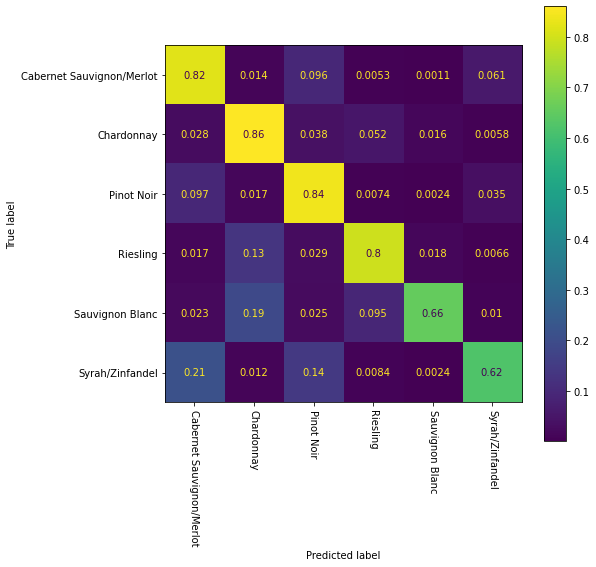

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd1, test_copy["review_text"], test_copy["wine_variant"],xticks_rotation=-90, normalize='true',ax=ax)

#### With the above labels it is clear to see that the performance increases by quite a significant margin, the f1 score goes up from 0.71 to 0.78, but this comes with the downside of having less certainty about the classification because you are bringing 2 distinct labels down to one composite label which could be either one of the original labels. For example if 3 labels are replaced by one label called say Cabernet/Merlot/Riesling, the F1 may increase but the point of classification is lost by generalizing the labels to that extent.
#### By doing more label reduction the performance could be taken up to an F1 of 0.85, but in this specific scenario the better solution would probably be to do the Margin calculation based label reductions. 